## Project 04
### James Grasell
### April 26, 2021

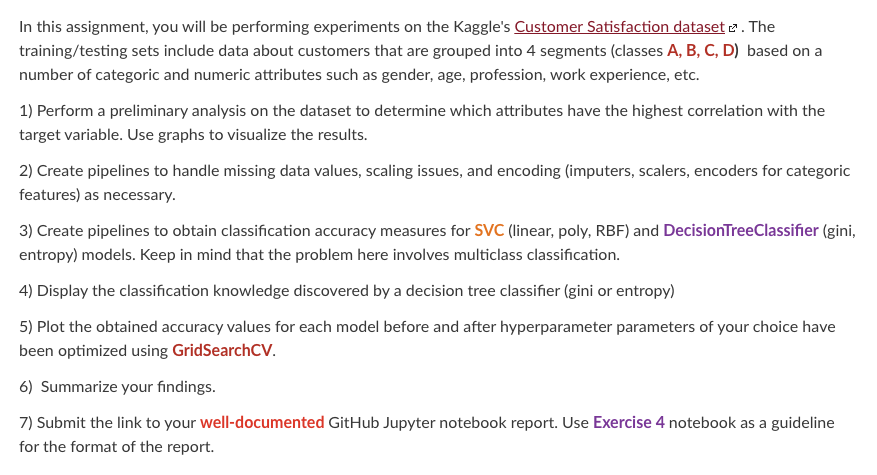

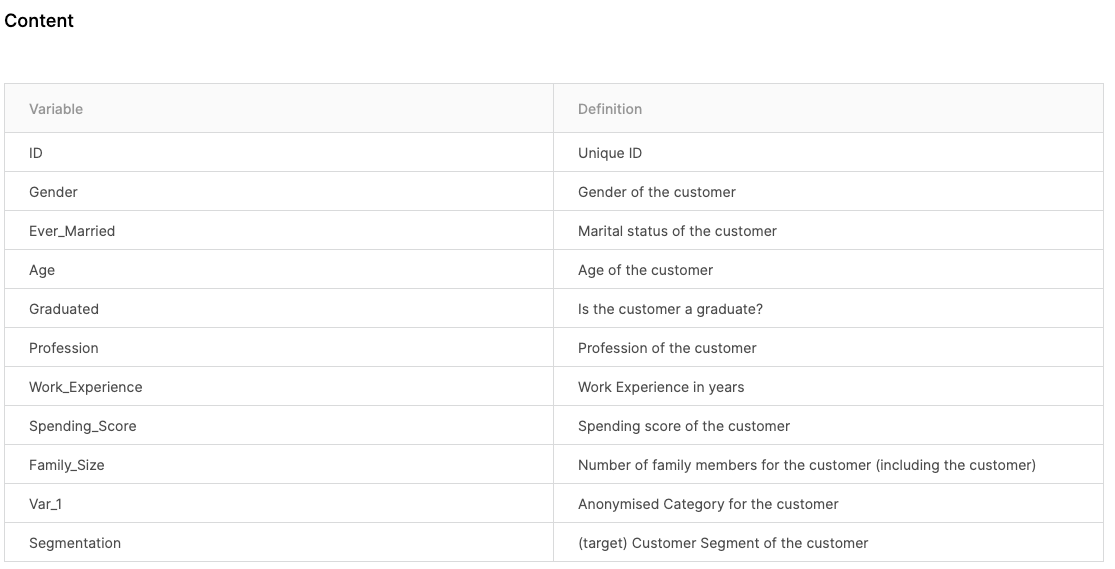

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
# Read in the Customer Segmentation data from github
train_url = 'https://raw.githubusercontent.com/jimgrasell/AML/master/Project04/Data/train.csv'
test_url = 'https://raw.githubusercontent.com/jimgrasell/AML/master/Project04/Data/test.csv'
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print('Shape of the train_df: ',df.shape)
print('Shape of the test_df: ',df.shape)
print(train_df.head())